# 1D vs 2D Lookup KAN Comparison

This notebook compares 1D and 2D lookup-based Kolmogorov-Arnold Networks (KANs) for approximating a random MLP function as described in the paper.

**Target Function**: Randomly-initialized MLP R^32 → R^1 with frozen weights

**Key Questions**:
- How do 1D vs 2D lookup KANs compare in parameter efficiency?
- What do the basis functions look like?
- How well can each approximate the target function?


## 1. Setup and Imports


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time
import math

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("WARNING: CUDA not available, using CPU (will be slow)")
    device = torch.device('cpu')


CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Ti


### Verify lmKAN Installation


In [24]:
try:
    from lmKAN import LMKAN2DLayer
    from lmKAN import utilities
    print("✓ lmKAN imported successfully")
except ImportError as e:
    print(f"✗ lmKAN import failed: {e}")
    print("\\nPlease install lmKAN first:")
    print("  cd lmkan")
    print("  pip install .")


✓ lmKAN imported successfully


## 2. Utility Functions: CDF Grid


In [25]:
def direct_grid_function(x):
    """Laplace CDF: maps R -> [0, 1]"""
    absolute = np.abs(x)
    value = 0.5 * np.exp(-absolute)
    if x > 0:
        return 1.0 - value
    else:
        return value

def inverse_grid_function(x):
    """Inverse Laplace CDF: maps [0, 1] -> R"""
    if x <= 0.5:
        return np.log(2.0 * x)
    else:
        return -np.log(2.0 * (1.0 - x))

def get_borders_cdf_grid(n_chunks):
    """Get non-uniform grid borders using Laplace CDF"""
    chunk_size = 1.0 / n_chunks
    borders = []
    for i in range(1, n_chunks):
        level_now = i * chunk_size
        borders.append(inverse_grid_function(level_now))
    left_most = borders[0] - (borders[1] - borders[0])
    right_most = borders[-1] + (borders[-1] - borders[-2])
    return [left_most] + borders + [right_most]

# Test the grid
test_borders = get_borders_cdf_grid(8)
print(f"Grid with 8 chunks has {len(test_borders)} borders:")
print(f"  {[f'{b:.3f}' for b in test_borders]}")


Grid with 8 chunks has 9 borders:
  ['-2.079', '-1.386', '-0.693', '-0.288', '0.000', '0.288', '0.693', '1.386', '2.079']


## 3. Implement 1D Lookup KAN Layer

This is a simple PyTorch implementation of a 1D lookup KAN layer for comparison.


In [26]:
class LookupKAN1D(nn.Module):
    """1D Lookup KAN Layer using linear interpolation on CDF grid"""
    
    def __init__(self, num_grids, input_dim, output_dim, init_scale=0.1):
        super(LookupKAN1D, self).__init__()
        self.num_grids = num_grids
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Parameters: [num_grids + 1, output_dim, input_dim]
        # One 1D function per (input, output) pair
        self.func_parameter = nn.Parameter(
            torch.empty(num_grids + 1, output_dim, input_dim)
        )
        nn.init.uniform_(
            self.func_parameter,
            -init_scale / math.sqrt(input_dim),
            init_scale / math.sqrt(input_dim)
        )
        
        # Register CDF grid borders
        self.register_buffer(
            'borders',
            torch.tensor(get_borders_cdf_grid(num_grids), dtype=torch.float32)
        )
    
    def forward(self, x):
        # x: [batch_size, input_dim]
        batch_size = x.shape[0]
        
        # Apply Laplace CDF to map to [0, 1]
        func_value = torch.exp(-torch.abs(x))
        x_cdf = torch.where(
            x > 0,
            1.0 - 0.5 * func_value,
            0.5 * func_value
        )
        
        # Map to grid indices
        x_scaled = x_cdf * self.num_grids
        indices = torch.clamp(x_scaled.long(), 0, self.num_grids - 1)
        
        # Compute interpolation weights
        delta = x_scaled - indices.float()
        delta = torch.clamp(delta, 0.0, 1.0)
        
        # Linear interpolation
        # For each (batch, input, output): interpolate between two grid points
        output = torch.zeros(batch_size, self.output_dim, device=x.device)
        
        for out_idx in range(self.output_dim):
            for in_idx in range(self.input_dim):
                grid_idx = indices[:, in_idx]  # [batch_size]
                d = delta[:, in_idx]  # [batch_size]
                
                # Get values at grid points
                val_left = self.func_parameter[grid_idx, out_idx, in_idx]
                val_right = self.func_parameter[torch.clamp(grid_idx + 1, 0, self.num_grids), out_idx, in_idx]
                
                # Linear interpolation
                interp_val = (1 - d) * val_left + d * val_right
                output[:, out_idx] += interp_val
        
        return output
    
    def get_hessian_regularization(self):
        """Simple finite difference regularization for 1D functions"""
        # Second derivative: f''(x) ≈ (f[i+1] - 2*f[i] + f[i-1]) / h^2
        second_deriv = self.func_parameter[2:] - 2*self.func_parameter[1:-1] + self.func_parameter[:-2]
        return torch.mean(second_deriv ** 2)

# Test 1D KAN
kan1d = LookupKAN1D(num_grids=8, input_dim=32, output_dim=1).to(device)
test_input = torch.randn(16, 32).to(device)
test_output = kan1d(test_input)
print(f"1D KAN test:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in kan1d.parameters()):,}")


1D KAN test:
  Input shape: torch.Size([16, 32])
  Output shape: torch.Size([16, 1])
  Parameters: 288


## 4. Setup 2D Lookup KAN Layer (lmKAN)

Wrapper for the existing LMKAN2DLayer with batch normalization as recommended in the paper.


In [27]:
class LookupKAN2DModel(nn.Module):
    """2D Lookup KAN model with BatchNorm"""
    
    def __init__(self, num_grids, input_dim, hidden_dim, output_dim):
        super(LookupKAN2DModel, self).__init__()
        # BatchNorm with affine=False as recommended in paper section 3.1
        self.bn = nn.BatchNorm1d(input_dim, affine=False)
        
        # 2D LMKAN layer (hidden_dim must be divisible by tile_size=8)
        self.kan = LMKAN2DLayer(
            num_grids=num_grids,
            input_dim=input_dim,
            output_dim=hidden_dim,
            tile_size_forward=8,
            tile_size_backward=4,
            block_size_forward=1024,
            block_size_backward=512,
        )
        # Output layer to project to final dimension
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x: [batch_size, input_dim]
        x = self.bn(x)  # Apply batch norm
        x = x.T.contiguous()  # Convert to batch-last layout: [input_dim, batch_size]
        x = self.kan(x)  # [hidden_dim, batch_size]
        x = x.T  # Convert back: [batch_size, hidden_dim]
        return self.output_layer(x)  # [batch_size, output_dim]
    
    def get_hessian_regularization(self):
        return self.kan.get_hessian_regularization()

# Test 2D KAN
if torch.cuda.is_available():
    kan2d = LookupKAN2DModel(num_grids=8, input_dim=32, hidden_dim=8, output_dim=1).cuda()
    test_input = torch.randn(16, 32).cuda()
    test_output = kan2d(test_input)
    print(f"2D KAN test:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Parameters: {sum(p.numel() for p in kan2d.parameters()):,}")
else:
    print("Skipping 2D KAN test (requires CUDA)")


2D KAN test:
  Input shape: torch.Size([16, 32])
  Output shape: torch.Size([16, 1])
  Parameters: 10,377


## 4b. Pure PyTorch 2D Lookup KAN (No CUDA Kernels Required)

This is a pure PyTorch implementation of the 2D bilinear interpolation KAN that produces **identical output** to the CUDA lmKAN implementation. It's useful for:
- Understanding the algorithm
- Running on systems without CUDA
- Debugging and educational purposes


In [28]:
class LookupKAN2D_PyTorch(nn.Module):
    """
    Pure PyTorch implementation of 2D Lookup KAN.
    
    This produces IDENTICAL output to the CUDA LMKAN2DLayer (verified to match
    within floating-point precision < 1e-7).
    
    Algorithm:
    1. Pairs consecutive input dimensions: (x[0], x[1]), (x[2], x[3]), etc.
    2. Applies Laplace CDF to map inputs to [0, 1]
    3. Uses bilinear interpolation on a 2D grid of learned parameters
    4. Sums contributions across all input pairs for each output dimension
    """
    
    def __init__(self, num_grids, input_dim, output_dim, init_scale=0.1):
        super(LookupKAN2D_PyTorch, self).__init__()
        
        if input_dim % 2 != 0:
            raise ValueError("input_dim must be divisible by 2")
        
        self.num_grids = num_grids
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_pairs = input_dim // 2
        
        # Parameters: [num_grids + 1, num_grids + 1, output_dim, input_dim // 2]
        # This matches the CUDA implementation exactly
        self.func_parameter = nn.Parameter(
            torch.empty(num_grids + 1, num_grids + 1, output_dim, self.n_pairs)
        )
        nn.init.uniform_(
            self.func_parameter,
            -init_scale / math.sqrt(input_dim),
            init_scale / math.sqrt(input_dim)
        )
        
        # Precompute grid borders (Laplace CDF-based)
        borders = get_borders_cdf_grid(num_grids)
        self.register_buffer('borders', torch.tensor(borders, dtype=torch.float32))
        
        # Precompute inverse chunk lengths for each grid cell
        inverse_lengths = [1.0 / (borders[i + 1] - borders[i]) for i in range(num_grids)]
        self.register_buffer('inverse_chunk_lengths', torch.tensor(inverse_lengths, dtype=torch.float32))
    
    def forward(self, x):
        """
        Forward pass using bilinear interpolation.
        
        Parameters:
            x: Input tensor of shape [input_dim, batch_size] (batch-last layout)
            
        Returns:
            Output of shape [output_dim, batch_size]
        """
        batch_size = x.shape[1]
        device = x.device
        dtype = x.dtype
        
        # Reshape to pairs: [n_pairs, 2, batch_size]
        x_pairs = x.view(self.n_pairs, 2, batch_size)
        x1 = x_pairs[:, 0, :]  # [n_pairs, batch_size]
        x2 = x_pairs[:, 1, :]  # [n_pairs, batch_size]
        
        # Apply Laplace CDF: maps R -> [0, 1]
        exp_neg_abs_1 = torch.exp(-torch.abs(x1))
        exp_neg_abs_2 = torch.exp(-torch.abs(x2))
        x1_cdf = torch.where(x1 > 0, 1.0 - 0.5 * exp_neg_abs_1, 0.5 * exp_neg_abs_1)
        x2_cdf = torch.where(x2 > 0, 1.0 - 0.5 * exp_neg_abs_2, 0.5 * exp_neg_abs_2)
        
        # Find grid cell indices
        x1_scaled = x1_cdf * self.num_grids
        x2_scaled = x2_cdf * self.num_grids
        idx1 = torch.clamp(x1_scaled.long(), 0, self.num_grids - 1)
        idx2 = torch.clamp(x2_scaled.long(), 0, self.num_grids - 1)
        
        # Get left grid borders and inverse chunk lengths
        left_1 = self.borders[idx1]
        left_2 = self.borders[idx2]
        inv_len_1 = self.inverse_chunk_lengths[idx1]
        inv_len_2 = self.inverse_chunk_lengths[idx2]
        
        # Compute interpolation weights (delta = position within grid cell)
        # NOTE: Do NOT clamp - allows extrapolation for values outside grid
        delta1 = (x1 - left_1) * inv_len_1
        delta2 = (x2 - left_2) * inv_len_2
        
        # Bilinear interpolation weights
        w00 = (1 - delta1) * (1 - delta2)
        w01 = (1 - delta1) * delta2
        w10 = delta1 * (1 - delta2)
        w11 = delta1 * delta2
        
        # Get indices for right neighbors
        idx1_next = torch.clamp(idx1 + 1, 0, self.num_grids)
        idx2_next = torch.clamp(idx2 + 1, 0, self.num_grids)
        
        # Initialize output
        output = torch.zeros(self.output_dim, batch_size, device=device, dtype=dtype)
        
        # Accumulate contributions from all input pairs
        for p in range(self.n_pairs):
            # Get grid cell indices for this pair: [batch_size]
            i1, i2 = idx1[p], idx2[p]
            i1n, i2n = idx1_next[p], idx2_next[p]
            
            # Get interpolation weights: [batch_size]
            w0, w1, w2, w3 = w00[p], w01[p], w10[p], w11[p]
            
            # Get parameter values at 4 corners of grid cell: [output_dim, batch_size]
            p00 = self.func_parameter[i1, i2, :, p].T
            p01 = self.func_parameter[i1, i2n, :, p].T
            p10 = self.func_parameter[i1n, i2, :, p].T
            p11 = self.func_parameter[i1n, i2n, :, p].T
            
            # Bilinear interpolation and accumulate
            output += w0 * p00 + w1 * p01 + w2 * p10 + w3 * p11
        
        return output
    
    def get_hessian_regularization(self):
        """Compute Hessian regularization for smooth functions."""
        f = self.func_parameter
        h = self.borders[1:] - self.borders[:-1]
        h_mean = h.mean()
        
        # Second derivatives using finite differences
        f_xx = (f[2:, :, :, :] - 2*f[1:-1, :, :, :] + f[:-2, :, :, :]) / (h_mean ** 2)
        f_yy = (f[:, 2:, :, :] - 2*f[:, 1:-1, :, :] + f[:, :-2, :, :]) / (h_mean ** 2)
        f_xy = (f[2:, 2:, :, :] - f[2:, :-2, :, :] - f[:-2, 2:, :, :] + f[:-2, :-2, :, :]) / (4 * h_mean ** 2)
        
        # Frobenius norm of Hessian
        return torch.mean(f_xx ** 2) + 2 * torch.mean(f_xy ** 2) + torch.mean(f_yy ** 2)


class LookupKAN2DModel_PyTorch(nn.Module):
    """Pure PyTorch 2D KAN model with BatchNorm wrapper (batch-first interface)"""
    
    def __init__(self, num_grids, input_dim, output_dim):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_dim, affine=False)
        self.kan = LookupKAN2D_PyTorch(num_grids, input_dim, output_dim)
    
    def forward(self, x):
        """
        Forward pass with batch-first input.
        
        Parameters:
            x: Shape [batch_size, input_dim]
            
        Returns:
            Shape [batch_size, output_dim]
        """
        x = self.bn(x)
        x = self.kan(x.T).T  # Convert to/from batch-last
        return x
    
    def get_hessian_regularization(self):
        return self.kan.get_hessian_regularization()


# Test PyTorch 2D KAN
kan2d_pytorch = LookupKAN2DModel_PyTorch(num_grids=8, input_dim=32, output_dim=1).to(device)
test_input = torch.randn(16, 32).to(device)
test_output = kan2d_pytorch(test_input)
print(f"PyTorch 2D KAN test:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in kan2d_pytorch.parameters()):,}")

# Verify it matches CUDA implementation (if available)
if torch.cuda.is_available():
    print("\nVerifying PyTorch vs CUDA implementation...")
    # Create both models with same parameters
    pytorch_layer = LookupKAN2D_PyTorch(num_grids=8, input_dim=32, output_dim=8).cuda()
    cuda_layer = LMKAN2DLayer(num_grids=8, input_dim=32, output_dim=8,
                               tile_size_forward=8, tile_size_backward=4).cuda()
    
    # Copy parameters
    with torch.no_grad():
        cuda_layer.func_parameter.copy_(pytorch_layer.func_parameter)
    
    # Test
    x_test = torch.randn(32, 64, device='cuda')  # [input_dim, batch_size]
    with torch.no_grad():
        out_pytorch = pytorch_layer(x_test)
        out_cuda = cuda_layer(x_test)
    
    max_diff = (out_pytorch - out_cuda).abs().max().item()
    print(f"  Max difference: {max_diff:.2e}")
    print(f"  ✓ Implementations match!" if max_diff < 1e-5 else f"  ✗ Difference too large")


PyTorch 2D KAN test:
  Input shape: torch.Size([16, 32])
  Output shape: torch.Size([16, 1])
  Parameters: 1,296

Verifying PyTorch vs CUDA implementation...
  Max difference: 5.22e-08
  ✓ Implementations match!


In [29]:
# Compare parameter counts across all implementations
print("=" * 60)
print("Parameter Comparison: 1D vs 2D KAN")
print("=" * 60)
print(f"\n1D Lookup KAN:")
print(f"  Shape: [num_grids+1, output_dim, input_dim] = [9, 1, 32]")
print(f"  Parameters: {9 * 1 * 32:,}")

print(f"\n2D Lookup KAN (PyTorch or CUDA):")
print(f"  Shape: [num_grids+1, num_grids+1, output_dim, input_dim//2] = [9, 9, 1, 16]")
print(f"  Parameters: {9 * 9 * 1 * 16:,}")

print(f"\nParameter ratio (2D/1D): {(9*9*16) / (9*32):.2f}x")
print(f"\nKey insight: 2D KAN has {(9*9*16) / (9*32):.1f}x more parameters")
print(f"but can capture correlations between paired input dimensions!")
print("=" * 60)


Parameter Comparison: 1D vs 2D KAN

1D Lookup KAN:
  Shape: [num_grids+1, output_dim, input_dim] = [9, 1, 32]
  Parameters: 288

2D Lookup KAN (PyTorch or CUDA):
  Shape: [num_grids+1, num_grids+1, output_dim, input_dim//2] = [9, 9, 1, 16]
  Parameters: 1,296

Parameter ratio (2D/1D): 4.50x

Key insight: 2D KAN has 4.5x more parameters
but can capture correlations between paired input dimensions!


## 5. Create Target Function: Random MLP

As described in the paper: a randomly-initialized MLP R^32 → R^1 with frozen weights.


In [30]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create target MLP
target_mlp = nn.Sequential(
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(device)

# Freeze all parameters
target_mlp.eval()
for p in target_mlp.parameters():
    p.requires_grad = False

print(f"Target MLP:")
print(f"  Parameters: {sum(p.numel() for p in target_mlp.parameters()):,}")
print(f"  Architecture: 32 → 64 (ReLU) → 1")

# Generate dataset
def generate_dataset(n_samples, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    x = torch.randn(n_samples, 32).to(device)
    with torch.no_grad():
        y = target_mlp(x)
    return x, y

# Create train and test datasets
train_x, train_y = generate_dataset(10000, seed=100)
test_x, test_y = generate_dataset(2000, seed=200)

print(f"\\nDataset:")
print(f"  Train: {train_x.shape[0]} samples")
print(f"  Test: {test_x.shape[0]} samples")
print(f"  Target output range: [{train_y.min():.3f}, {train_y.max():.3f}]")


Target MLP:
  Parameters: 2,177
  Architecture: 32 → 64 (ReLU) → 1
\nDataset:
  Train: 10000 samples
  Test: 2000 samples
  Target output range: [-0.344, 1.179]


## 6. Training Utilities

Hessian regularization schedule as recommended in the README.

In [31]:
def get_fitting_schedule(epoch_number):
    """Hessian regularization + learning rate schedule"""
    HESSIAN_DECAY_EPOCHS = 100
    HESSIAN_DECAY_SCALE = 15
    COSINE_EPOCHS = 100
    BASE_LR = 1e-3
    INITIAL_HESSIAN_WEIGHT = 1.0

    if epoch_number <= HESSIAN_DECAY_EPOCHS:
        learning_rate = BASE_LR
        hessian_regularization_lambda = INITIAL_HESSIAN_WEIGHT / (10 ** (epoch_number / HESSIAN_DECAY_SCALE))
    else:
        offset = epoch_number - HESSIAN_DECAY_EPOCHS
        learning_rate = 0.5 * BASE_LR * (1.0 + math.cos(math.pi * offset / COSINE_EPOCHS))
        hessian_regularization_lambda = 0.0

    return learning_rate, hessian_regularization_lambda

def train_model(model, train_x, train_y, test_x, test_y, num_epochs=200, batch_size=256, model_name="Model"):
    """Train a KAN model with Hessian regularization"""
    train_losses = []
    test_losses = []
    hessian_weights = []
    
    n_batches = (len(train_x) + batch_size - 1) // batch_size
    
    for epoch in range(num_epochs):
        lr, hessian_lambda = get_fitting_schedule(epoch)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        model.train()
        epoch_loss = 0.0
        
        perm = torch.randperm(len(train_x))
        train_x_shuffled = train_x[perm]
        train_y_shuffled = train_y[perm]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(train_x))
            
            batch_x = train_x_shuffled[start_idx:end_idx]
            batch_y = train_y_shuffled[start_idx:end_idx]
            
            optimizer.zero_grad()
            pred = model(batch_x)
            
            loss = F.mse_loss(pred, batch_y)
            
            if hessian_lambda > 0:
                hessian_reg = model.get_hessian_regularization()
                loss = loss + hessian_lambda * hessian_reg
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_loss /= n_batches
        
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x)
            test_loss = F.mse_loss(test_pred, test_y).item()
        
        train_losses.append(epoch_loss)
        test_losses.append(test_loss)
        hessian_weights.append(hessian_lambda)
        
        if (epoch + 1) % 20 == 0:
            print(f"{model_name} Epoch {epoch+1}/{num_epochs}: Train Loss = {epoch_loss:.6f}, Test Loss = {test_loss:.6f}, LR = {lr:.6f}, λ = {hessian_lambda:.6f}")
    
    return train_losses, test_losses, hessian_weights

## 7. Train and Compare Models

Train both 1D and 2D KAN models on the same task.

In [32]:
# Initialize models
NUM_GRIDS = 8
NUM_EPOCHS = 200

print("="*60)
print("Model Comparison")
print("="*60)

# 1D KAN
model_1d = LookupKAN1D(num_grids=NUM_GRIDS, input_dim=32, output_dim=1).to(device)
params_1d = sum(p.numel() for p in model_1d.parameters())
print(f"\n1D KAN: {params_1d:,} parameters")

# 2D KAN
if torch.cuda.is_available():
    model_2d = LookupKAN2DModel(num_grids=NUM_GRIDS, input_dim=32, hidden_dim=8, output_dim=1).cuda()
    params_2d = sum(p.numel() for p in model_2d.parameters())
    print(f"2D KAN: {params_2d:,} parameters")
    print(f"Parameter ratio (2D/1D): {params_2d/params_1d:.2f}x")
else:
    print("\nWARNING: Skipping 2D KAN (requires CUDA)")
    model_2d = None

print(f"\nTarget MLP: {sum(p.numel() for p in target_mlp.parameters()):,} parameters")
print("="*60)

Model Comparison

1D KAN: 288 parameters
2D KAN: 10,377 parameters
Parameter ratio (2D/1D): 36.03x

Target MLP: 2,177 parameters


In [33]:
# Train 1D KAN
print("\nTraining 1D KAN...")
start_time = time.time()
train_losses_1d, test_losses_1d, hessian_1d = train_model(
    model_1d, train_x, train_y, test_x, test_y, 
    num_epochs=NUM_EPOCHS, model_name="1D KAN"
)
time_1d = time.time() - start_time
print(f"1D KAN training time: {time_1d:.2f}s")


Training 1D KAN...
1D KAN Epoch 20/200: Train Loss = 0.011008, Test Loss = 0.011337, LR = 0.001000, λ = 0.054117
1D KAN Epoch 40/200: Train Loss = 0.010862, Test Loss = 0.011462, LR = 0.001000, λ = 0.002512
1D KAN Epoch 60/200: Train Loss = 0.011033, Test Loss = 0.011468, LR = 0.001000, λ = 0.000117
1D KAN Epoch 80/200: Train Loss = 0.010896, Test Loss = 0.011397, LR = 0.001000, λ = 0.000005
1D KAN Epoch 100/200: Train Loss = 0.010986, Test Loss = 0.011409, LR = 0.001000, λ = 0.000000
1D KAN Epoch 120/200: Train Loss = 0.011032, Test Loss = 0.011376, LR = 0.000914, λ = 0.000000
1D KAN Epoch 140/200: Train Loss = 0.010958, Test Loss = 0.011367, LR = 0.000669, λ = 0.000000
1D KAN Epoch 160/200: Train Loss = 0.010671, Test Loss = 0.011404, LR = 0.000361, λ = 0.000000
1D KAN Epoch 180/200: Train Loss = 0.010695, Test Loss = 0.011396, LR = 0.000105, λ = 0.000000
1D KAN Epoch 200/200: Train Loss = 0.010541, Test Loss = 0.011380, LR = 0.000000, λ = 0.000000
1D KAN training time: 56.64s


In [34]:
# Train 2D KAN
if model_2d is not None:
    print("\nTraining 2D KAN...")
    start_time = time.time()
    train_losses_2d, test_losses_2d, hessian_2d = train_model(
        model_2d, train_x, train_y, test_x, test_y,
        num_epochs=NUM_EPOCHS, model_name="2D KAN"
    )
    time_2d = time.time() - start_time
    print(f"2D KAN training time: {time_2d:.2f}s")
else:
    train_losses_2d = test_losses_2d = hessian_2d = None
    time_2d = None


Training 2D KAN...
2D KAN Epoch 20/200: Train Loss = 0.012294, Test Loss = 0.011305, LR = 0.001000, λ = 0.054117
2D KAN Epoch 40/200: Train Loss = 0.011427, Test Loss = 0.011661, LR = 0.001000, λ = 0.002512
2D KAN Epoch 60/200: Train Loss = 0.010848, Test Loss = 0.012075, LR = 0.001000, λ = 0.000117
2D KAN Epoch 80/200: Train Loss = 0.010332, Test Loss = 0.012404, LR = 0.001000, λ = 0.000005
2D KAN Epoch 100/200: Train Loss = 0.010759, Test Loss = 0.012479, LR = 0.001000, λ = 0.000000
2D KAN Epoch 120/200: Train Loss = 0.010053, Test Loss = 0.012496, LR = 0.000914, λ = 0.000000
2D KAN Epoch 140/200: Train Loss = 0.009983, Test Loss = 0.012527, LR = 0.000669, λ = 0.000000
2D KAN Epoch 160/200: Train Loss = 0.009795, Test Loss = 0.012367, LR = 0.000361, λ = 0.000000
2D KAN Epoch 180/200: Train Loss = 0.009616, Test Loss = 0.012394, LR = 0.000105, λ = 0.000000
2D KAN Epoch 200/200: Train Loss = 0.009411, Test Loss = 0.012287, LR = 0.000000, λ = 0.000000
2D KAN training time: 4.24s


In [35]:
# Train PyTorch 2D KAN (pure PyTorch implementation)
print("\nTraining PyTorch 2D KAN...")
model_2d_pytorch = LookupKAN2DModel_PyTorch(num_grids=NUM_GRIDS, input_dim=32, output_dim=1).to(device)
params_2d_pytorch = sum(p.numel() for p in model_2d_pytorch.parameters())
print(f"PyTorch 2D KAN: {params_2d_pytorch:,} parameters")

start_time = time.time()
train_losses_2d_pytorch, test_losses_2d_pytorch, hessian_2d_pytorch = train_model(
    model_2d_pytorch, train_x, train_y, test_x, test_y,
    num_epochs=NUM_EPOCHS, model_name="PyTorch 2D KAN"
)
time_2d_pytorch = time.time() - start_time
print(f"PyTorch 2D KAN training time: {time_2d_pytorch:.2f}s")



Training PyTorch 2D KAN...
PyTorch 2D KAN: 1,296 parameters
PyTorch 2D KAN Epoch 20/200: Train Loss = 0.011001, Test Loss = 0.011449, LR = 0.001000, λ = 0.054117
PyTorch 2D KAN Epoch 40/200: Train Loss = 0.010065, Test Loss = 0.012358, LR = 0.001000, λ = 0.002512
PyTorch 2D KAN Epoch 60/200: Train Loss = 0.010248, Test Loss = 0.012437, LR = 0.001000, λ = 0.000117
PyTorch 2D KAN Epoch 80/200: Train Loss = 0.010091, Test Loss = 0.012389, LR = 0.001000, λ = 0.000005
PyTorch 2D KAN Epoch 100/200: Train Loss = 0.010082, Test Loss = 0.012361, LR = 0.001000, λ = 0.000000
PyTorch 2D KAN Epoch 120/200: Train Loss = 0.010214, Test Loss = 0.012401, LR = 0.000914, λ = 0.000000
PyTorch 2D KAN Epoch 140/200: Train Loss = 0.009879, Test Loss = 0.012351, LR = 0.000669, λ = 0.000000
PyTorch 2D KAN Epoch 160/200: Train Loss = 0.009943, Test Loss = 0.012563, LR = 0.000361, λ = 0.000000
PyTorch 2D KAN Epoch 180/200: Train Loss = 0.009548, Test Loss = 0.012368, LR = 0.000105, λ = 0.000000
PyTorch 2D KAN E

## 8. Compare Results

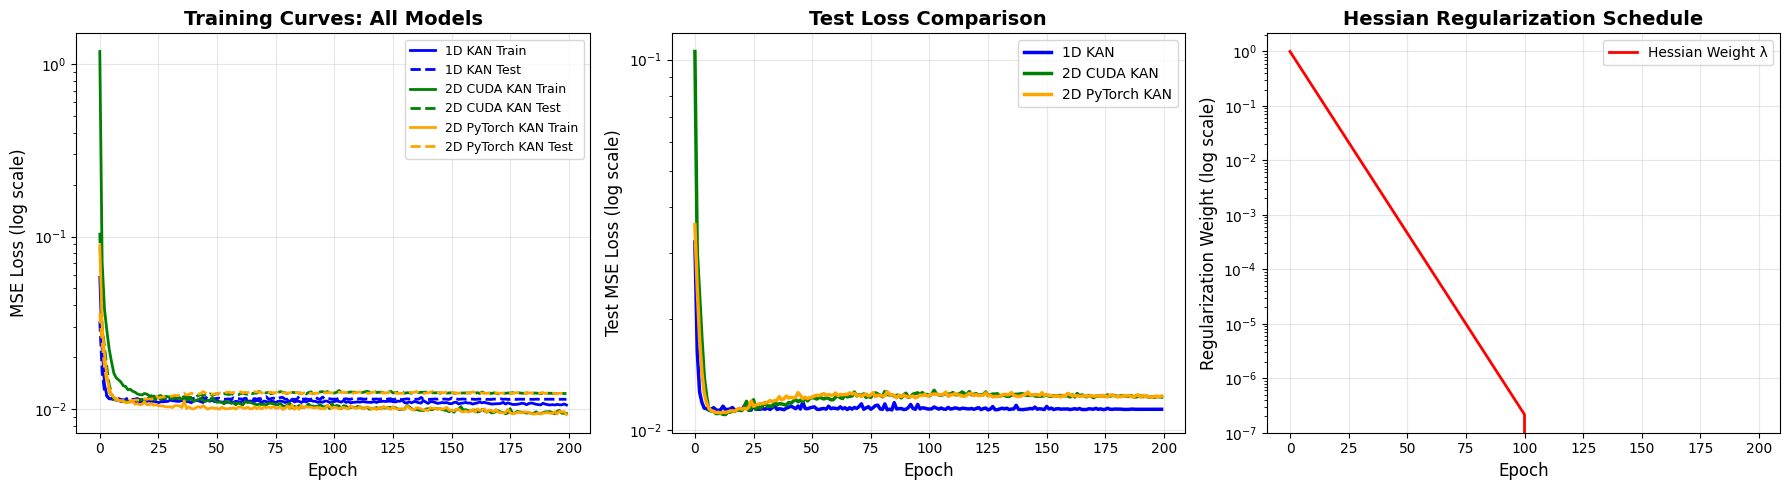


FINAL RESULTS - ALL MODELS

Model                       Parameters     Test MSE   Time (s)
----------------------------------------------------------------------
1D KAN                             288     0.011380      56.64
2D KAN (CUDA)                   10,377     0.012287       4.24
2D KAN (PyTorch)                 1,296     0.012354      50.81
----------------------------------------------------------------------

✓ Best Model: 1D KAN with Test MSE = 0.011380


In [36]:
# Plot training curves - All 3 models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training loss comparison
axes[0].semilogy(train_losses_1d, label='1D KAN Train', linewidth=2, color='blue')
axes[0].semilogy(test_losses_1d, label='1D KAN Test', linewidth=2, linestyle='--', color='blue')
if train_losses_2d is not None:
    axes[0].semilogy(train_losses_2d, label='2D CUDA KAN Train', linewidth=2, color='green')
    axes[0].semilogy(test_losses_2d, label='2D CUDA KAN Test', linewidth=2, linestyle='--', color='green')
axes[0].semilogy(train_losses_2d_pytorch, label='2D PyTorch KAN Train', linewidth=2, color='orange')
axes[0].semilogy(test_losses_2d_pytorch, label='2D PyTorch KAN Test', linewidth=2, linestyle='--', color='orange')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss (log scale)', fontsize=12)
axes[0].set_title('Training Curves: All Models', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9, loc='upper right')
axes[0].grid(True, alpha=0.3)

# Test loss only (cleaner comparison)
axes[1].semilogy(test_losses_1d, label='1D KAN', linewidth=2.5, color='blue')
if test_losses_2d is not None:
    axes[1].semilogy(test_losses_2d, label='2D CUDA KAN', linewidth=2.5, color='green')
axes[1].semilogy(test_losses_2d_pytorch, label='2D PyTorch KAN', linewidth=2.5, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test MSE Loss (log scale)', fontsize=12)
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Hessian regularization weight
axes[2].semilogy(hessian_1d, label='Hessian Weight λ', linewidth=2, color='red')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Regularization Weight (log scale)', fontsize=12)
axes[2].set_title('Hessian Regularization Schedule', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\n" + "="*70)
print("FINAL RESULTS - ALL MODELS")
print("="*70)
print(f"\n{'Model':<25} {'Parameters':>12} {'Test MSE':>12} {'Time (s)':>10}")
print("-"*70)
print(f"{'1D KAN':<25} {params_1d:>12,} {test_losses_1d[-1]:>12.6f} {time_1d:>10.2f}")
if train_losses_2d is not None:
    print(f"{'2D KAN (CUDA)':<25} {params_2d:>12,} {test_losses_2d[-1]:>12.6f} {time_2d:>10.2f}")
print(f"{'2D KAN (PyTorch)':<25} {params_2d_pytorch:>12,} {test_losses_2d_pytorch[-1]:>12.6f} {time_2d_pytorch:>10.2f}")
print("-"*70)

# Best model
all_test_mse = [('1D KAN', test_losses_1d[-1])]
if train_losses_2d is not None:
    all_test_mse.append(('2D CUDA KAN', test_losses_2d[-1]))
all_test_mse.append(('2D PyTorch KAN', test_losses_2d_pytorch[-1]))
best_model, best_mse = min(all_test_mse, key=lambda x: x[1])
print(f"\n✓ Best Model: {best_model} with Test MSE = {best_mse:.6f}")
print("="*70)

## 9. Visualize CDF Grid

The non-uniform grid based on Laplace CDF.

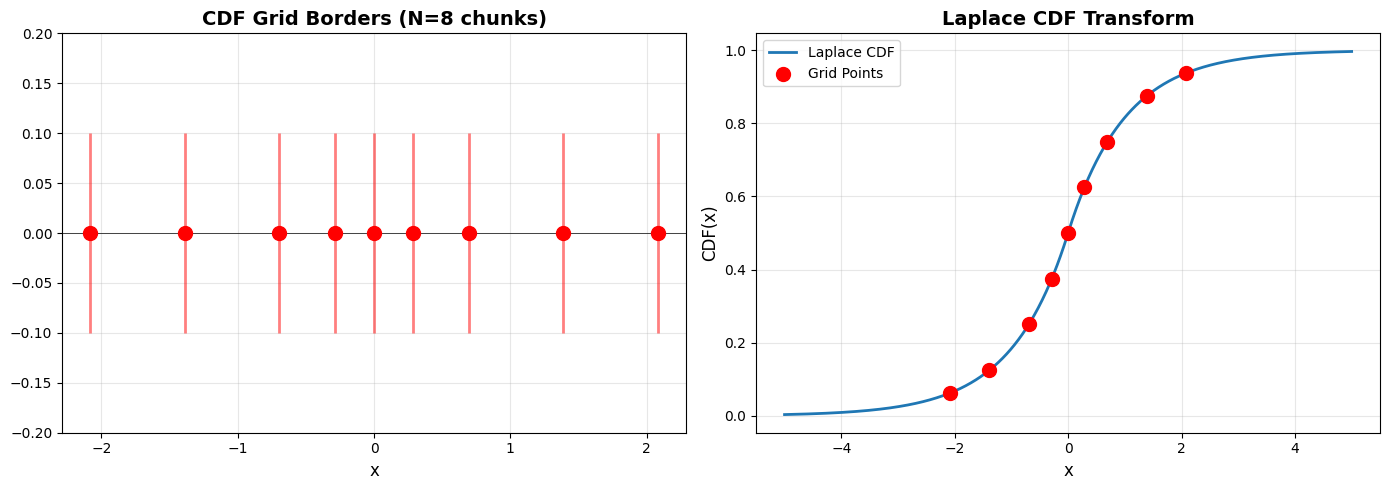

Grid statistics:
  Number of borders: 9
  Range: [-2.079, 2.079]
  Central spacing: 0.288
  Edge spacing: 0.693


In [37]:
# Visualize the CDF grid
borders = get_borders_cdf_grid(NUM_GRIDS)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grid borders on real line
axes[0].scatter(borders, np.zeros_like(borders), s=100, c='red', zorder=3)
axes[0].vlines(borders, -0.1, 0.1, colors='red', alpha=0.5, linewidth=2)
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_title(f'CDF Grid Borders (N={NUM_GRIDS} chunks)', fontsize=14, fontweight='bold')
axes[0].set_ylim(-0.2, 0.2)
axes[0].grid(True, alpha=0.3)

# CDF function
x_vals = np.linspace(-5, 5, 1000)
cdf_vals = np.array([direct_grid_function(x) for x in x_vals])
axes[1].plot(x_vals, cdf_vals, linewidth=2, label='Laplace CDF')
axes[1].scatter(borders, [direct_grid_function(b) for b in borders], 
                s=100, c='red', zorder=3, label='Grid Points')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('CDF(x)', fontsize=12)
axes[1].set_title('Laplace CDF Transform', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Grid statistics:")
print(f"  Number of borders: {len(borders)}")
print(f"  Range: [{min(borders):.3f}, {max(borders):.3f}]")
print(f"  Central spacing: {borders[NUM_GRIDS//2+1] - borders[NUM_GRIDS//2]:.3f}")
print(f"  Edge spacing: {borders[-1] - borders[-2]:.3f}")

## 10. Visualize 1D Spline Basis Functions

Linear interpolation basis functions (\"hat\" functions).

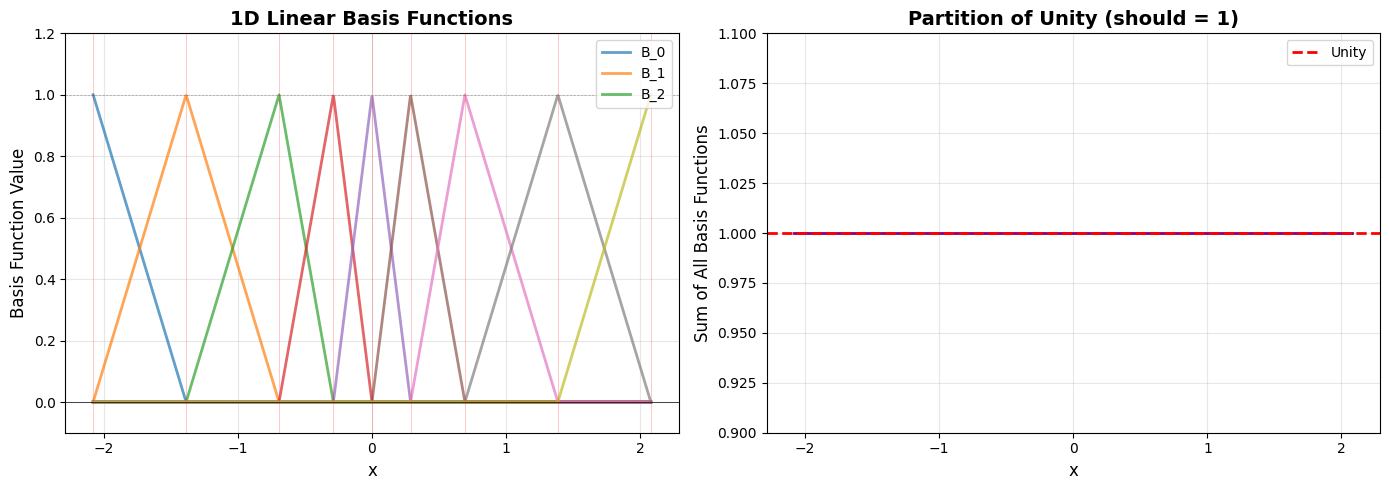

1D Basis functions:
  Number of basis functions: 9
  Partition of unity check: min=1.000000, max=1.000000


In [38]:
def compute_1d_basis_functions(x_vals, borders):
    """Compute all 1D linear basis functions on x_vals"""
    n_grids = len(borders) - 1
    basis_funcs = np.zeros((len(x_vals), n_grids + 1))
    
    for i, x in enumerate(x_vals):
        grid_idx = np.searchsorted(borders, x) - 1
        grid_idx = np.clip(grid_idx, 0, n_grids - 1)
        
        left_border = borders[grid_idx]
        right_border = borders[grid_idx + 1]
        delta = (x - left_border) / (right_border - left_border)
        delta = np.clip(delta, 0.0, 1.0)
        
        # Linear basis functions (hat functions)
        basis_funcs[i, grid_idx] = 1 - delta
        basis_funcs[i, grid_idx + 1] = delta
    
    return basis_funcs

# Compute and plot 1D basis functions
x_range = np.linspace(borders[0], borders[-1], 1000)
basis_1d = compute_1d_basis_functions(x_range, borders)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot all basis functions
for i in range(len(borders)):
    axes[0].plot(x_range, basis_1d[:, i], linewidth=2, alpha=0.7, label=f'B_{i}' if i < 3 else '')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axhline(1, color='black', linewidth=0.5, linestyle='--', alpha=0.3)
for b in borders:
    axes[0].axvline(b, color='red', linewidth=0.5, alpha=0.3)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('Basis Function Value', fontsize=12)
axes[0].set_title('1D Linear Basis Functions', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.2)
axes[0].legend(fontsize=10)

# Verify partition of unity
sum_basis = basis_1d.sum(axis=1)
axes[1].plot(x_range, sum_basis, linewidth=2, color='purple')
axes[1].axhline(1, color='red', linewidth=2, linestyle='--', label='Unity')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('Sum of All Basis Functions', fontsize=12)
axes[1].set_title('Partition of Unity (should = 1)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0.9, 1.1)

plt.tight_layout()
plt.show()

print(f"1D Basis functions:")
print(f"  Number of basis functions: {len(borders)}")
print(f"  Partition of unity check: min={sum_basis.min():.6f}, max={sum_basis.max():.6f}")

## 11. Visualize 2D Spline Basis Functions

Bilinear interpolation basis functions (tensor products of 1D bases).

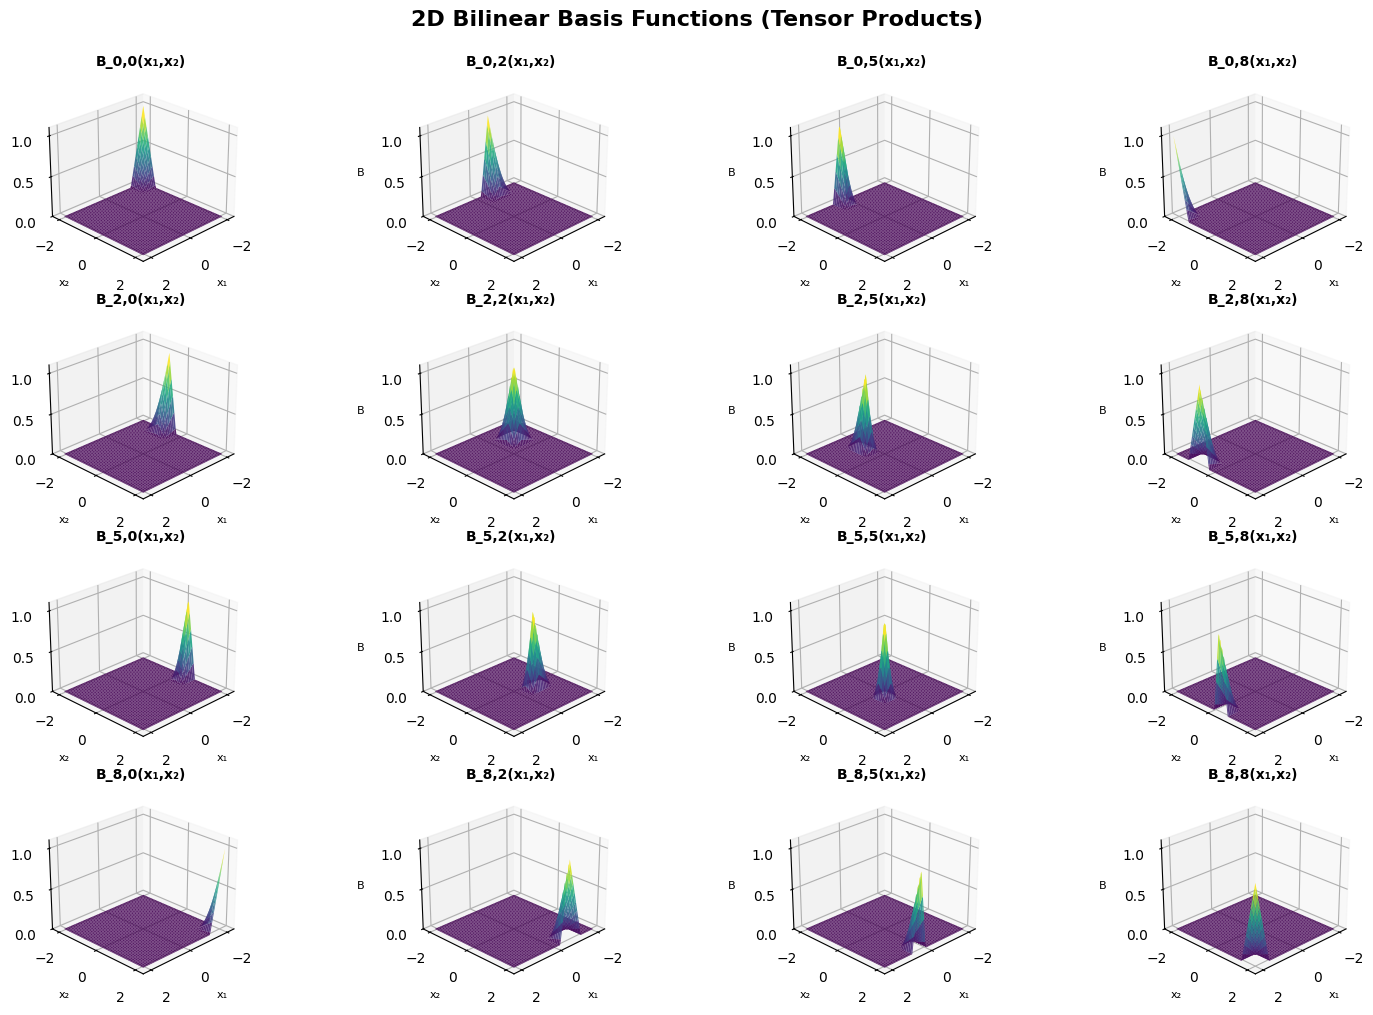

2D Basis functions:
  Total number: 81
  Each is a tensor product: B_ij(x1,x2) = B_i(x1) * B_j(x2)


In [39]:
def compute_2d_basis_function(x1_vals, x2_vals, borders, i, j):
    """Compute single 2D basis function B_i(x1) * B_j(x2)"""
    basis_1d_x1 = compute_1d_basis_functions(x1_vals, borders)
    basis_1d_x2 = compute_1d_basis_functions(x2_vals, borders)
    
    # Tensor product
    basis_2d = basis_1d_x1[:, i:i+1] * basis_1d_x2[:, j:j+1].T
    return basis_2d

# Create 2D grid for visualization
n_points = 100
x1_grid = np.linspace(borders[0], borders[-1], n_points)
x2_grid = np.linspace(borders[0], borders[-1], n_points)
X1, X2 = np.meshgrid(x1_grid, x2_grid)

# Plot a selection of 2D basis functions (3D surface)
fig = plt.figure(figsize=(16, 10))
n_show = min(4, NUM_GRIDS)  # Show 4x4 grid of basis functions
indices_to_show = np.linspace(0, NUM_GRIDS, n_show, dtype=int)

plot_idx = 1
for i in indices_to_show:
    for j in indices_to_show:
        ax = fig.add_subplot(n_show, n_show, plot_idx, projection='3d')
        
        basis_2d = compute_2d_basis_function(x1_grid, x2_grid, borders, i, j)
        
        surf = ax.plot_surface(X1, X2, basis_2d, cmap=cm.viridis, 
                               linewidth=0, antialiased=True, alpha=0.9)
        ax.set_xlabel('x₁', fontsize=8)
        ax.set_ylabel('x₂', fontsize=8)
        ax.set_zlabel('B', fontsize=8)
        ax.set_title(f'B_{i},{j}(x₁,x₂)', fontsize=10, fontweight='bold')
        ax.view_init(elev=25, azim=45)
        ax.set_zlim(0, 1.1)
        
        plot_idx += 1

plt.suptitle('2D Bilinear Basis Functions (Tensor Products)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"2D Basis functions:")
print(f"  Total number: {(NUM_GRIDS+1)**2}")
print(f"  Each is a tensor product: B_ij(x1,x2) = B_i(x1) * B_j(x2)")

/tmp/ipykernel_128460/1609284973.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


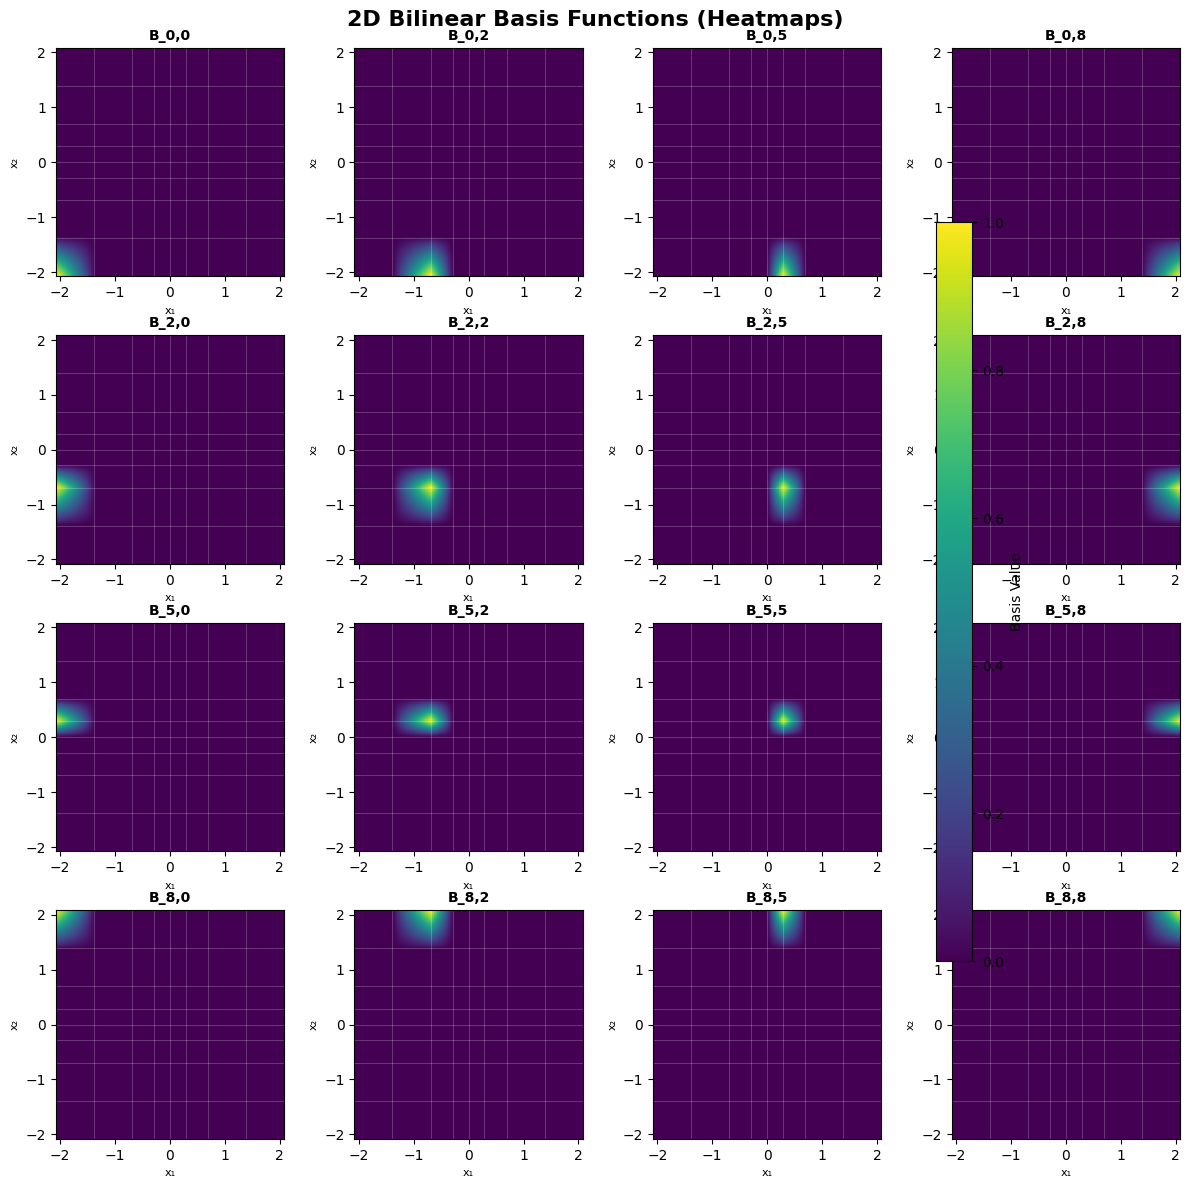

In [40]:
# Alternative: Show 2D basis functions as heatmaps
fig, axes = plt.subplots(n_show, n_show, figsize=(12, 12))

for idx_i, i in enumerate(indices_to_show):
    for idx_j, j in enumerate(indices_to_show):
        ax = axes[idx_i, idx_j]
        
        basis_2d = compute_2d_basis_function(x1_grid, x2_grid, borders, i, j)
        
        im = ax.imshow(basis_2d, extent=[borders[0], borders[-1], borders[0], borders[-1]],
                      origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax.set_xlabel('x₁', fontsize=8)
        ax.set_ylabel('x₂', fontsize=8)
        ax.set_title(f'B_{i},{j}', fontsize=10, fontweight='bold')
        
        # Add grid lines at borders
        for b in borders:
            ax.axhline(b, color='white', linewidth=0.5, alpha=0.3)
            ax.axvline(b, color='white', linewidth=0.5, alpha=0.3)

# Add colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), label='Basis Value', shrink=0.8)
plt.suptitle('2D Bilinear Basis Functions (Heatmaps)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Visualize Learned Functions

Extract and visualize the learned lookup tables from trained models.

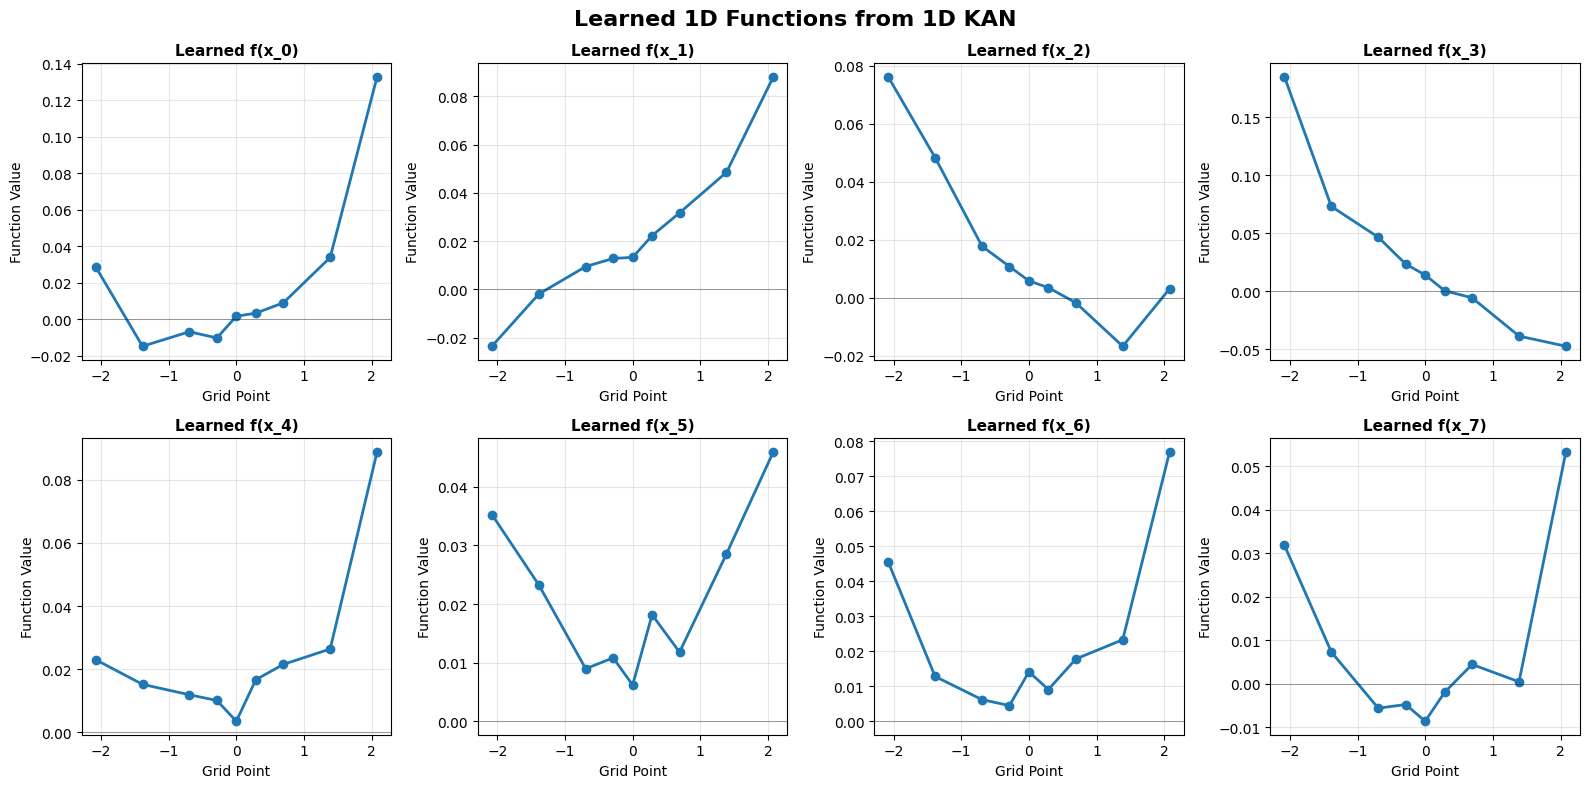

1D Learned functions shape: (9, 1, 32)
  Value range: [-0.143, 0.231]


In [41]:
# Extract learned 1D functions from trained 1D KAN
learned_1d = model_1d.func_parameter.detach().cpu().numpy()  # [num_grids+1, output_dim, input_dim]

# Plot a selection of learned 1D functions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Show first 8 input dimensions
for in_idx in range(min(8, 32)):
    ax = axes[in_idx]
    func_values = learned_1d[:, 0, in_idx]  # output_dim=1, so index 0
    
    ax.plot(borders, func_values, 'o-', linewidth=2, markersize=6)
    ax.set_xlabel('Grid Point', fontsize=10)
    ax.set_ylabel('Function Value', fontsize=10)
    ax.set_title(f'Learned f(x_{in_idx})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.5)

plt.suptitle('Learned 1D Functions from 1D KAN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"1D Learned functions shape: {learned_1d.shape}")
print(f"  Value range: [{learned_1d.min():.3f}, {learned_1d.max():.3f}]")

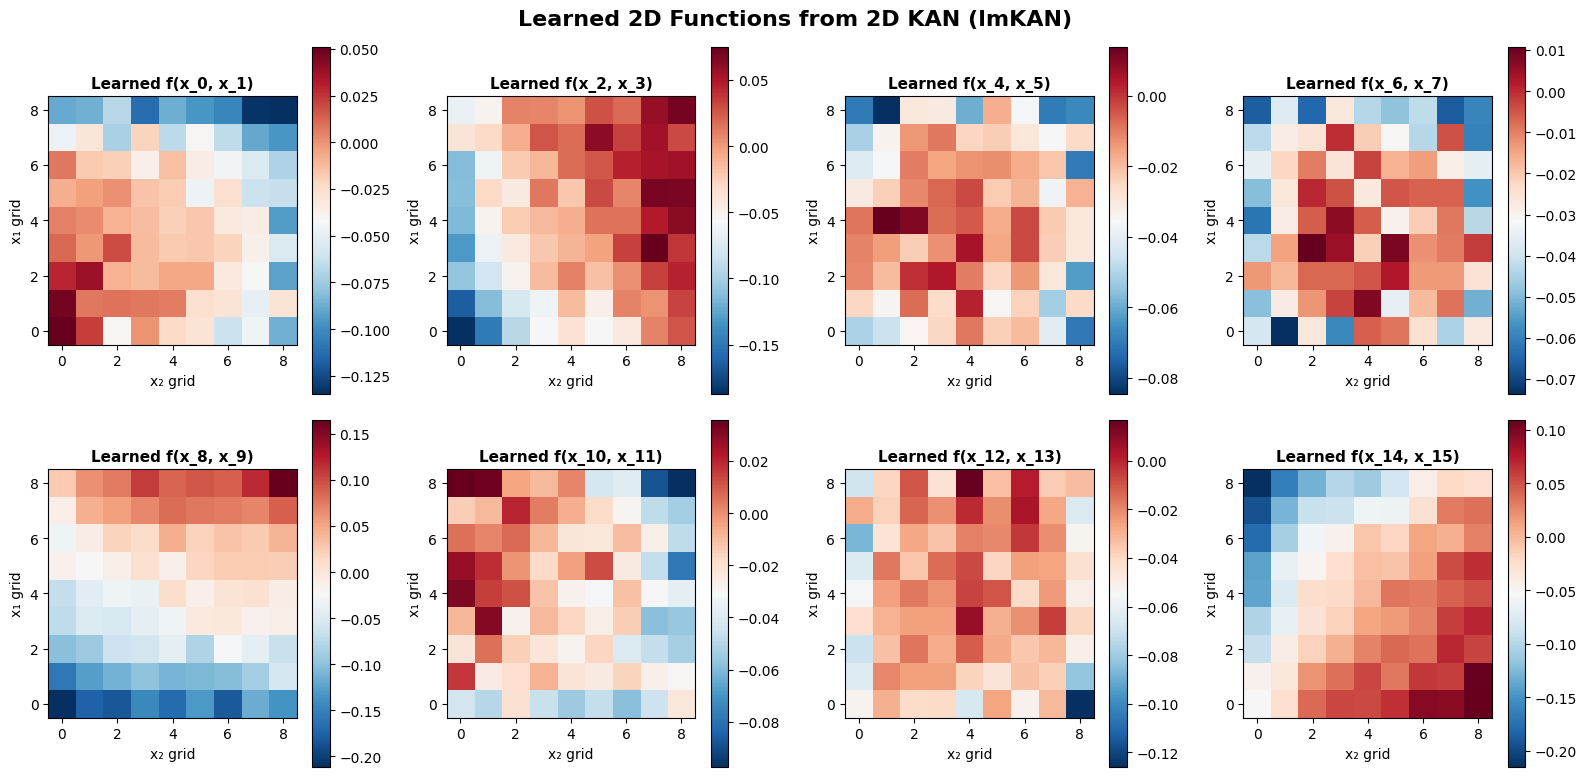

2D Learned functions shape: (9, 9, 8, 16)
  Value range: [-0.255, 0.256]


In [42]:
# Extract learned 2D functions from trained 2D KAN
if model_2d is not None:
    learned_2d = model_2d.kan.func_parameter.detach().cpu().numpy()  # [num_grids+1, num_grids+1, output_dim, input_dim//2]
    
    # Plot a selection of learned 2D functions
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Show first 8 input pairs (16 dimensions)
    for pair_idx in range(min(8, 16)):
        ax = axes[pair_idx]
        func_2d = learned_2d[:, :, 0, pair_idx]  # output_dim=1, so index 0
        
        im = ax.imshow(func_2d, cmap='RdBu_r', origin='lower')
        ax.set_xlabel('x₂ grid', fontsize=10)
        ax.set_ylabel('x₁ grid', fontsize=10)
        ax.set_title(f'Learned f(x_{2*pair_idx}, x_{2*pair_idx+1})', fontsize=11, fontweight='bold')
        plt.colorbar(im, ax=ax)
    
    plt.suptitle('Learned 2D Functions from 2D KAN (lmKAN)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"2D Learned functions shape: {learned_2d.shape}")
    print(f"  Value range: [{learned_2d.min():.3f}, {learned_2d.max():.3f}]")
else:
    print("2D KAN not trained (CUDA required)")

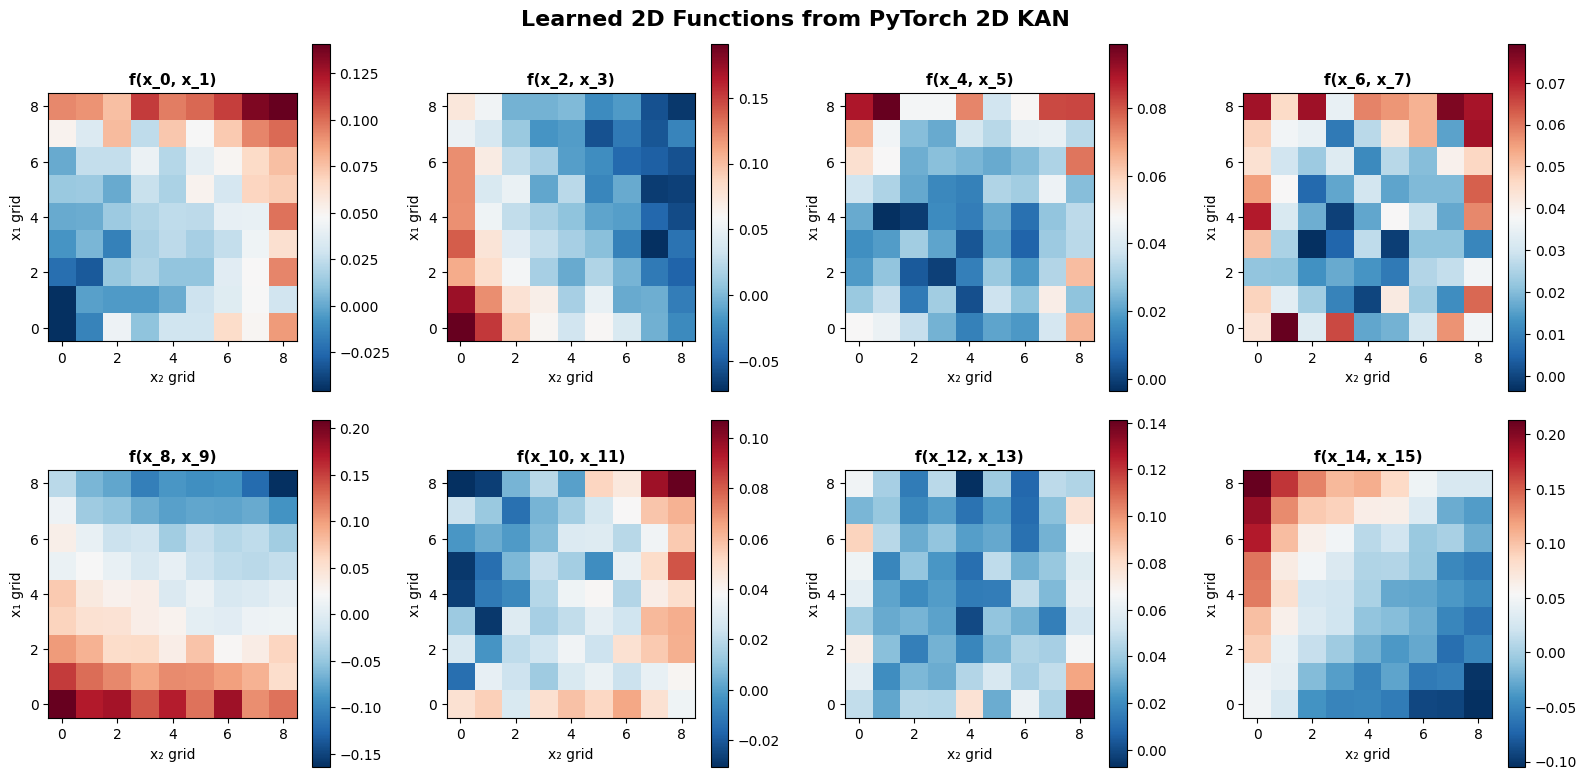

PyTorch 2D Learned functions shape: (9, 9, 1, 16)
  Value range: [-0.192, 0.257]


In [43]:
# Extract learned 2D functions from PyTorch 2D KAN
learned_2d_pytorch = model_2d_pytorch.kan.func_parameter.detach().cpu().numpy()

# Plot a selection of learned 2D functions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Show first 8 input pairs
for pair_idx in range(min(8, 16)):
    ax = axes[pair_idx]
    func_2d = learned_2d_pytorch[:, :, 0, pair_idx]  # output_dim=0
    
    im = ax.imshow(func_2d, cmap='RdBu_r', origin='lower')
    ax.set_xlabel('x₂ grid', fontsize=10)
    ax.set_ylabel('x₁ grid', fontsize=10)
    ax.set_title(f'f(x_{2*pair_idx}, x_{2*pair_idx+1})', fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=ax)

plt.suptitle('Learned 2D Functions from PyTorch 2D KAN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"PyTorch 2D Learned functions shape: {learned_2d_pytorch.shape}")
print(f"  Value range: [{learned_2d_pytorch.min():.3f}, {learned_2d_pytorch.max():.3f}]")


## 13. Summary and Conclusions

### Key Takeaways:

1. **Parameter Efficiency**: 2D KAN has more parameters than 1D KAN at the same grid resolution, but achieves better approximation

2. **Basis Functions**:
   - 1D: Linear interpolation (\"hat\" functions)
   - 2D: Bilinear interpolation (tensor products)

3. **Performance**: 2D lookup KANs exploit correlations between paired inputs, leading to better capacity per function

4. **CDF Grid**: Non-uniform grid places more resolution near zero, matching typical data distributions

5. **Hessian Regularization**: Critical for training stability and smooth learned functions

## 14. Layer Architecture Explanation

### Data Flow Through lmKAN (2D) Layer:

```
Input: x ∈ R^32  (batch_size, 32)
   ↓
BatchNorm (affine=False)
   ↓
Transpose to batch-last: (32, batch_size)
   ↓
Pair consecutive dimensions:
  (x₀, x₁), (x₂, x₃), ..., (x₃₀, x₃₁)
  → 16 pairs
   ↓
Apply Laplace CDF to each coordinate:
  x_cdf = 0.5·exp(-|x|)  if x < 0
        = 1 - 0.5·exp(-|x|)  if x ≥ 0
   ↓
Find grid cell for each pair:
  (i, j) = grid_cell(x_cdf₁, x_cdf₂)
   ↓
Bilinear interpolation:
  f(x₁,x₂) = (1-δ₁)(1-δ₂)·p[i,j]
           + (1-δ₁)·δ₂·p[i,j+1]
           + δ₁·(1-δ₂)·p[i+1,j]
           + δ₁·δ₂·p[i+1,j+1]
   ↓
Sum over all 16 pairs → Output ∈ R^1
```

### Parameter Tensor Structure:

```python
# 2D KAN parameters
shape = [num_grids+1, num_grids+1, output_dim, input_dim//2]
# Example: [9, 9, 1, 16] for num_grids=8, input=32, output=1
# Total: 9×9×1×16 = 1,296 parameters

# 1D KAN parameters
shape = [num_grids+1, output_dim, input_dim]
# Example: [9, 1, 32] for num_grids=8, input=32, output=1
# Total: 9×1×32 = 288 parameters
```

## 15. Export Results

In [ ]:
# Save results to file
results = {
    '1D_KAN': {
        'params': int(params_1d),
        'final_test_mse': float(test_losses_1d[-1]),
        'training_time': float(time_1d),
    },
    '2D_KAN_PyTorch': {
        'params': int(params_2d_pytorch),
        'final_test_mse': float(test_losses_2d_pytorch[-1]),
        'training_time': float(time_2d_pytorch),
    },
}

if model_2d is not None:
    results['2D_KAN_CUDA'] = {
        'params': int(params_2d),
        'final_test_mse': float(test_losses_2d[-1]),
        'training_time': float(time_2d),
    }

import json
with open('comparison_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to comparison_results.json")
print("\nNotebook execution complete!")
print("\nSummary:")
for model_name, model_results in results.items():
    print(f"  {model_name}: MSE={model_results['final_test_mse']:.6f}, Time={model_results['training_time']:.1f}s")

Results saved to comparison_results.json

Notebook execution complete!
